In [1]:
import cv2
import os

import torch
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob

import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.checkpoint import checkpoint

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
def display_image_with_mask(image: torch.tensor, mask: np.ndarray, alpha: float = 0.5):
    """
    Display a grayscale image with a binary mask overlaid.

    Parameters:
    - image: 2D tensor for a scan
    - mask:  2D numpy array of same shape with binary values (0 or 1).
    - alpha: float transparency for mask overlay.
    """
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, alpha=alpha)
    plt.axis('off')
    plt.show()

In [4]:
# This class stores a scan slice image and its associated mask
class ScanSlice:
    def __init__(self, file_path, shape, transform=None):
        self.file_path = file_path
        self.transform = transform
        self.shape = shape

        # format the file name properly
        case_path = file_path.split('/')
        slice_name = case_path[-1].split('_')

        # name is the name in the train.csv file
        # original shape is the shape of the raw image before transform
        self.name = f"{case_path[-3]}_slice_{slice_name[1]}"
        self.original_shape = (int(slice_name[2]), int(slice_name[3]))

        # apply a default mask
        self.mask = np.zeros(self.shape, dtype=np.uint8)
        self.masks = {"stomach": np.zeros(self.shape, dtype=np.uint8),
                      "small_bowel": np.zeros(self.shape, dtype=np.uint8),
                      "large_bowel": np.zeros(self.shape, dtype=np.uint8)}

        # init the mask values that we will use
        self.mask_values = {"large_bowel": 1, "small_bowel": 2, "stomach": 3}

    def features(self, device="cpu", dtype=torch.float):
        # load image into memory
        img_data = cv2.imread(self.file_path, cv2.IMREAD_UNCHANGED)

        # format the data accordingly
        result = self.transform(img_data)
        result = result.to(dtype=dtype)
        result.to(device)

        return result

    def decode_rle(self, rle, label):
        # make sure the rle is not empty
        if not rle or (type(rle) is not str and np.isnan(rle)) or rle.strip() == "":
            return

        s = list(map(int, rle.strip().split()))
        starts, lengths = s[::2], s[1::2]
        starts = np.array(starts)
        ends = starts + lengths

        mask = np.zeros(self.original_shape[0] * self.original_shape[1], dtype=np.uint8)
        for start, end in zip(starts, ends):
            mask[start:end] = 1

        mask = cv2.resize(mask.reshape(self.original_shape), self.shape, interpolation=cv2.INTER_NEAREST)
        self.masks[label] = mask

        self.mask[mask == 1] = self.mask_values[label]

        allowed = {0, 1, 2, 3}
        unique_vals = np.unique(mask)

        if not set(unique_vals).issubset(allowed):
            raise Exception("An invalid value was found in a sample mask")


class MRIData(Dataset):
    def __init__(self, transform, slice_shape, device="cpu"):
        self.slices = dict()
        self.slice_index = list()

        self.device = device
        self.transform = transform
        self.slice_shape = slice_shape

        self.read_slice_data()
        self.read_rles()

    def __getitem__(self, idx):
        if type(idx) == str:
            return self.slices[idx].features(device=self.device), self.slices[idx].mask.astype(np.int64)
        return self.slice_index[idx].features(device=self.device), self.slice_index[idx].mask.astype(np.int64)

    def __len__(self):
        return len(self.slices)

    def get_slice(self, idx):
        if type(idx) == str:
            return self.slices[idx]
        return self.slice_index[idx]

    def read_slice_data(self):
        # get all of the slice paths
        slices = glob(f"{os.getcwd()}/gi-tract-data/train/*/*/scans/slice_*")
        slices = [slice.replace("\\", "/") for slice in slices]

        # create a slice object for every slice
        for slice_path in slices:
            ss = ScanSlice(slice_path, self.slice_shape, self.transform)
            self.slice_index.append(ss)
            self.slices[ss.name] = ss

    def read_rles(self):
        # open the train.csv file
        train_csv_path = f"{os.getcwd()}/gi-tract-data/train.csv"
        rle_file = pd.read_csv(train_csv_path)

        # give each slice its rle
        for i in range(0, len(rle_file)):
            slice_name, label, rle = rle_file.iloc[i]
            self.slices[slice_name].decode_rle(rle, label)

    def display_image_with_mask(self, idx):
        img, mask = self[idx]
        plt.figure()
        plt.imshow(img.squeeze(), cmap='gray')
        plt.imshow(mask, alpha=0.5)
        plt.axis('off')
        plt.show()

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

mrid = MRIData(transform, (256, 256), device=device)
training_data = Subset(mrid, list(range(6000)))
train_loader= DataLoader(training_data, batch_size=16, shuffle=True)

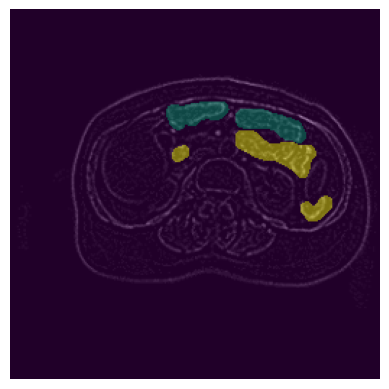

In [6]:
mrid.display_image_with_mask("case77_day20_slice_0115")

In [7]:
class DiceLoss(nn.Module):
    """
    Multi‑class Dice loss.
    Expects:
      - logits: (B, C, H, W) raw network outputs
      - targets: (B, H, W) integer class labels in [0..C-1]
    """
    def __init__(self, smooth: float = 1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # Number of classes from logits shape
        num_classes = logits.shape[1]

        # Convert to probabilities
        probs = F.softmax(logits, dim=1)

        # One‑hot encode targets to shape (B, C, H, W)
        with torch.no_grad():
            targets_one_hot = F.one_hot(targets, num_classes)  # (B, H, W, C)
            targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()

        # Compute per‑class Dice score
        dims = (0, 2, 3)  # sum over batch & spatial dims
        intersection = torch.sum(probs * targets_one_hot, dims)
        cardinality  = torch.sum(probs + targets_one_hot, dims)
        dice_score   = (2. * intersection + self.smooth) / (cardinality + self.smooth)

        # Dice loss is 1 – mean Dice score across classes
        return 1. - dice_score.mean()

class CombinedLoss(nn.Module):
    """
    α * CrossEntropy + (1-α) * DiceLoss
    """
    def __init__(self, alpha: float = 0.5, weight: torch.Tensor = None, ignore_index: int = -100):
        """
        Args:
          alpha       – weight for the CrossEntropy term (in [0,1])
          weight      – optional tensor of shape (C,) to weight classes in CE
          ignore_index– optional index to ignore in CE and Dice
        """
        super().__init__()
        self.alpha = alpha
        self.ce    = nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index)
        self.dice  = DiceLoss()

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        logits: (B, C, H, W)
        targets: (B, H, W)
        """
        loss_ce   = self.ce(logits, targets)
        loss_dice = self.dice(logits, targets)
        return self.alpha * loss_ce + (1. - self.alpha) * loss_dice

In [8]:
# Define a double convolution block: (Conv -> BatchNorm -> ReLU) * 2
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Downsampling block: MaxPool then DoubleConv
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class BottleneckResBlock(nn.Module):
    def __init__(self, in_channels, dropout_prob=0.1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_prob),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels)
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(x + self.conv(x))

# Upsampling block: Upsample (or ConvTranspose2d) then DoubleConv.
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1 is from the previous layer (decoder), x2 is from the encoder (skip connection)
        x1 = self.up(x1)
        # pad x1 if necessary to match dimensions of x2
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # concatenate along the channel dimension
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Final output convolution to reduce the number of channels to the desired number of classes.
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [9]:
# this reduces memory problems with cuda
torch.cuda.empty_cache()

In [10]:
# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.bottleneck = BottleneckResBlock(1024)
        self.up1 = Up(1536, 512)
        self.up2 = Up(768, 256)
        self.up3 = Up(384, 128)
        self.up4 = Up(192, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x5 = self.bottleneck(x5)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [11]:
model = UNet(n_channels=1, n_classes=4)
model.to(device)

pos_weight = torch.tensor([5.0], device=device)
criterion = CombinedLoss(alpha=0.05)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [12]:
num_epochs = 300

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode.
    train_loss = 0.0

    for inputs, targets in train_loader:

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Move the data to the proper device.
        inputs = inputs.to(device)
        targets = targets.to(device)

        # do the training stuff
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Accumulate the loss for this batch.
        train_loss += loss.item() * inputs.size(0)

    # Compute average training loss.
    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f}")

C:\Users\Josh\AppData\Local\Temp\ipykernel_32100\2426355354.py:23: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  train_loss += loss.item() * inputs.size(0)


Epoch 1/300 - Training Loss: 0.7072
Epoch 2/300 - Training Loss: 0.4768
Epoch 3/300 - Training Loss: 0.3259
Epoch 4/300 - Training Loss: 0.2733
Epoch 5/300 - Training Loss: 0.2532
Epoch 6/300 - Training Loss: 0.2367
Epoch 7/300 - Training Loss: 0.2308
Epoch 8/300 - Training Loss: 0.2224
Epoch 9/300 - Training Loss: 0.2159
Epoch 10/300 - Training Loss: 0.2116
Epoch 11/300 - Training Loss: 0.2085
Epoch 12/300 - Training Loss: 0.2101
Epoch 13/300 - Training Loss: 0.2017
Epoch 14/300 - Training Loss: 0.1961
Epoch 15/300 - Training Loss: 0.1968
Epoch 16/300 - Training Loss: 0.2003
Epoch 17/300 - Training Loss: 0.1912
Epoch 18/300 - Training Loss: 0.1900
Epoch 19/300 - Training Loss: 0.1865
Epoch 20/300 - Training Loss: 0.1883
Epoch 21/300 - Training Loss: 0.1851
Epoch 22/300 - Training Loss: 0.1819
Epoch 23/300 - Training Loss: 0.1878
Epoch 24/300 - Training Loss: 0.1870
Epoch 25/300 - Training Loss: 0.1795
Epoch 26/300 - Training Loss: 0.1773
Epoch 27/300 - Training Loss: 0.1779
Epoch 28/3

In [13]:
# save the model
torch.save(model.state_dict(), 'model_6000_300_a_v4.ai')

In [14]:
# load the model
model = UNet(n_channels=1, n_classes=4)
model.load_state_dict(torch.load('model_6000_300_a_v4.ai'))
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

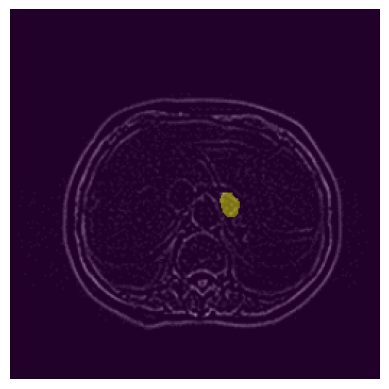

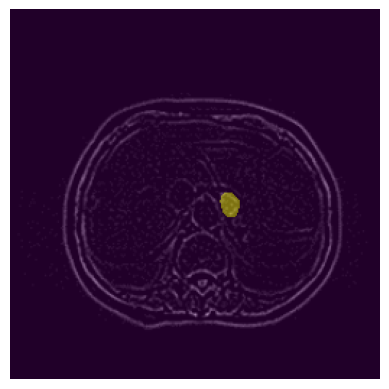

In [15]:
# errors with: case133_day25_slice_0049, All of day 77
X, y = mrid["case139_day0_slice_0062"]
y[y != 0] = 1

display_image_with_mask(X.squeeze(), y)

X_pred = X.unsqueeze(0).to(device)
y_pred = model(X_pred)

y_pred = torch.argmax(y_pred, dim=1)
y_pred[y_pred != 0] = 1

y_print = y_pred.detach().cpu().numpy()
display_image_with_mask(X.squeeze(), y_print.squeeze())